<a href="https://colab.research.google.com/github/gabriquaranta/thesis/blob/main/SAM_drone_segmentation_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!kaggle datasets download dasmehdixtr/drone-dataset-uav

!unzip -q drone-dataset-uav.zip
!rm -rf ./dataset_xml_format/
!rm -rf ./drone-dataset-uav.zip


Dataset URL: https://www.kaggle.com/datasets/dasmehdixtr/drone-dataset-uav
License(s): copyright-authors
100% 714M/716M [00:08<00:00, 111MB/s]
100% 716M/716M [00:08<00:00, 90.9MB/s]


In [3]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ezczahz4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ezczahz4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=3106f81853785d4e22d97faa0d6d57b130a349eabfdf151e84ef161059c9b9a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-z2yhsotb/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-02-13 17:10:28--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.15,

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

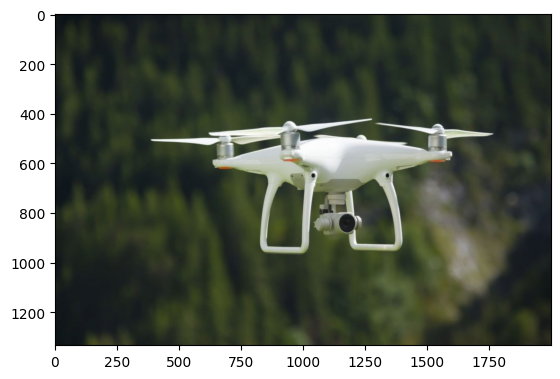

In [49]:
image = cv2.imread('/content/drone_dataset_yolo/dataset_txt/0004.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.axis('on')
plt.show()

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [10]:
predictor.set_image(image)

In [11]:
input_box_path='/content/drone_dataset_yolo/dataset_txt/0004.txt'


In [59]:

import matplotlib.pyplot as plt
import numpy as np

def read_bounding_box(input_box_path):
    with open(input_box_path, 'r') as file:
        lines = file.readlines()

    if lines:
        line = lines[0].strip().split()
        bbox = np.array([float(x) for x in line[1:]])  # Assuming bounding box is after class label
        return bbox
    else:
        return None



[0.549 0.523 0.735 0.481]


[0.549 0.523 0.735 0.481]
[ 363.     376.855 1833.    1018.509]


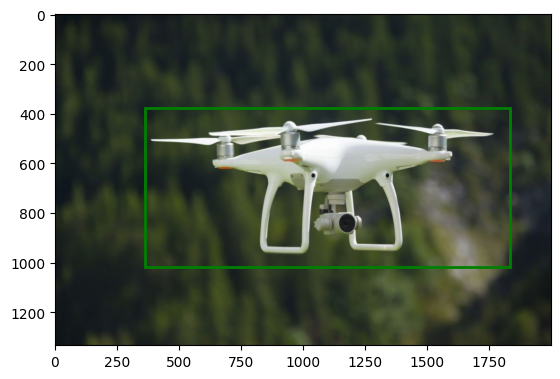

In [67]:
input_box = read_bounding_box(input_box_path)
print(input_box) # centerx centery width height

img_w,img_h=image.shape[1],image.shape[0]
input_box[0],input_box[1]=input_box[0]*img_w,input_box[1]*img_h
input_box[2],input_box[3]=input_box[2]*img_w,input_box[3]*img_h

x0, y0 = input_box[0] - input_box[2] / 2, input_box[1] - input_box[3] / 2
x1, y1 = input_box[0] + input_box[2] / 2, input_box[1] + input_box[3] / 2
input_box = np.array([x0, y0, x1, y1])
print(input_box)

plt.figure()
plt.imshow(image)
show_box(input_box, plt.gca())
plt.show()

In [68]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)

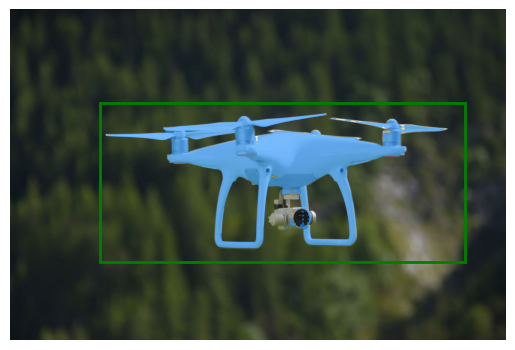

In [69]:
plt.figure()
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()